In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import matplotlib

from itertools import permutations
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import tree

In [6]:
# Partition features
def used_together(partition, used):
    """Are the used members all in the same partition?"""
    p_list = partition.split("_")
    used_idx = [i for u in used for i, p in enumerate(p_list) if u in p]
    return all(used_idx[0] == pi for pi in used_idx)


def number_of_subsets(partition):
    """How many subsets are there in the partition?"""
    return int(len(partition.split("_")))


def used_not_mixed_with_unused(partition, used):
    """Are the used members isolated from the unused members?"""
    p_list = partition.split("_")

    # Find subset each used member belongs to
    used_idx = [i for u in used for i, p in enumerate(p_list) if u in p]

    # For each subset that contains used members, check if it only contains used members
    for ui in used_idx:
        n_used = sum(1 for member in p_list[ui] if member in used)
        if n_used != len(p_list[ui]):
            return False

    return True


def used_alone(partition, used):
    """Are the used members alone in their subsets?"""
    p_list = partition.split("_")
    # Find subset each used member belongs to
    used_idx = [i for u in used for i, p in enumerate(p_list) if u in p]
    return all(len(p_list[i]) == 1 for i in used_idx)

In [7]:
print(used_not_mixed_with_unused("0_1234_56", ["1", "2", "3", "4"]))
print(used_not_mixed_with_unused("0_1_2_3_4_56", ["1", "2", "3", "4"]))
print(used_not_mixed_with_unused("0_12_34_56", ["1", "2", "3", "4"]))
print(used_not_mixed_with_unused("0_1_23_4_56",["1", "2", "3", "4"]))
print(used_not_mixed_with_unused("0_1_23_45_6",["1", "2", "3", "4"]))

True
True
True
True
False


In [8]:
# input = "/data/data-layout-benchmarks/260126/260126-vec"
input = "/data/data-layout-benchmarks/260128/260128-10reps-vec"
# input = "/data/data-layout-benchmarks/260130/260130-contig-vec"
df_vec = pd.read_csv(
    input, dtype={"problem_size": np.uintp, "container_byte_size": np.uintp}
)
df_vec["vectorized"] = True
assert df_vec.isna().sum().sum() == 0  # Check that there are no missing values
# df_concat = df_vec.copy()

# input = "/data/data-layout-benchmarks/260126/260126-novec"
input = "/data/data-layout-benchmarks/260128/260128-10reps-novec"
df_novec = pd.read_csv(
    input, dtype={"problem_size": np.uintp, "container_byte_size": np.uintp}
)
df_novec["vectorized"] = False
assert df_novec.isna().sum().sum() == 0  # Check that there are no missing values

df_concat = pd.concat([df_vec, df_novec], ignore_index=True)
df_concat["n_subsets"] = df_concat["container"].apply(lambda c: number_of_subsets(c))

df_concat["used_members"] = df_concat["benchmark"].apply(
    lambda b: ["2", "3"] if b == "DeltaR2Pairwise" else ["1", "2", "3", "4"]
)
df_concat["used_together"] = [
    used_together(c, m)
    for c, m in zip(df_concat["container"], df_concat["used_members"])
]
df_concat["used_not_mixed_with_unused"] = [
    used_not_mixed_with_unused(c, m)
    for c, m in zip(df_concat["container"], df_concat["used_members"])
]
df_concat["used_alone"] = [
    used_alone(c, m) for c, m in zip(df_concat["container"], df_concat["used_members"])
]

In [9]:
# Apply one hot encoding to the n_subsets column and keep the other columns unchanged
ct = ColumnTransformer(
    transformers=[("ohc", OneHotEncoder(sparse_output=False), ["n_subsets"])],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
ct.set_output(transform="pandas")
df = ct.fit_transform(df_concat)
df

,n_subsets_1,n_subsets_2,n_subsets_3,n_subsets_4,n_subsets_5,n_subsets_6,n_subsets_7,benchmark,container,problem_size,container_byte_size,time_unit,time,vectorized,used_members,used_together,used_not_mixed_with_unused,used_alone
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,InvariantMassSequential,PartitionedContainer0123456,91,16,ms,0.062111,True,"[1, 2, 3, 4]",True,False,False
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,InvariantMassSequential,PartitionedContainer0123456,91,16,ms,0.013580,True,"[1, 2, 3, 4]",True,False,False
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,InvariantMassSequential,PartitionedContainer0123456,91,16,ms,0.010900,True,"[1, 2, 3, 4]",True,False,False
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,InvariantMassSequential,PartitionedContainer0123456,91,16,ms,0.010681,True,"[1, 2, 3, 4]",True,False,False
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,InvariantMassSequential,PartitionedContainer0123456,91,16,ms,0.010600,True,"[1, 2, 3, 4]",True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2842675,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DeltaR2Pairwise,PartitionedContainer0_1_2_3_4_5_6,279620,64,ms,127.000000,False,"[2, 3]",False,True,True
2842676,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DeltaR2Pairwise,PartitionedContainer0_1_2_3_4_5_6,279620,64,ms,126.983000,False,"[2, 3]",False,True,True
2842677,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DeltaR2Pairwise,PartitionedContainer0_1_2_3_4_5_6,279620,64,ms,127.028000,False,"[2, 3]",False,True,True
2842678,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DeltaR2Pairwise,PartitionedContainer0_1_2_3_4_5_6,279620,64,ms,126.962000,False,"[2, 3]",False,True,True


In [10]:
feature_columns = [
    "vectorized",
    "used_together",
    "used_not_mixed_with_unused",
    "used_alone",
    # "n_subsets_1",
    # "n_subsets_2",
    # "n_subsets_3",
    # "n_subsets_4",
    # "n_subsets_5",
    # "n_subsets_6",
    # "n_subsets_7",
]

In [11]:
def get_clustering_input(df):
    return df["time"]
    # return df.groupby(["container", "vectorized"])["time"].mean()


def get_train_test_set(df, Y):
    # X = df.groupby(["container", "vectorized"])[feature_columns].first()
    X = df[feature_columns]

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, shuffle=True
    )

    return X_train, X_test, Y_train, Y_test

In [12]:
def kmeans_clustering_1D(data, n_clusters, xlabel="Data points", ylabel=""):
    reshaped_data = data.values.reshape(-1, 1)
    inertias = []
    max_k = 10
    for i in range(1, max_k):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(reshaped_data)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.subplot(121)
    plt.plot(range(1, max_k), inertias, marker="o")
    plt.title("Elbow method")
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")

    plt.subplot(122)
    plt.title(f"KMeans Clustering (k={n_clusters})")
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(reshaped_data)
    for label in np.unique(kmeans.labels_):
        plt.hist(
            data[kmeans.labels_ == label],
            alpha=0.5,
            bins="auto",
            label=f"Cluster {label}",
        )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yscale("log")
    plt.legend()

    plt.tight_layout()
    plt.show()
    return kmeans

In [13]:
def regression_tree_1D(X_train, X_test, Y_train, Y_test):
    reg_tree = tree.DecisionTreeRegressor()
    reg_tree.fit(X_train, Y_train)
    #######

    path = reg_tree.cost_complexity_pruning_path(X_train, Y_train)
    cpp_alphas = path.ccp_alphas
    cpp_alphas = cpp_alphas[:-1]  # Exclude the maximum value which prunes everything

    ########
    alpha_loop_values = []

    for ccp_a in cpp_alphas:
        reg_tree = tree.DecisionTreeRegressor(ccp_alpha=ccp_a)
        scores = cross_val_score(reg_tree, X_train, Y_train, cv=5)
        alpha_loop_values.append([ccp_a, scores.mean(), scores.std()])

    alpha_loop_values = np.array(alpha_loop_values)
    plt.figure()
    plt.errorbar(
        alpha_loop_values[:, 0],
        alpha_loop_values[:, 1],
        yerr=alpha_loop_values[:, 2],
        marker="o",
        label="Mean Accuracy with Std Dev",
        ls="--",
    )
    plt.xlabel("Alpha")
    plt.ylabel("Cross-validated accuracy")
    plt.title("Cost Complexity Pruning:\nCross-validated accuracy vs alpha")
    plt.show()
    print("Alphas:", alpha_loop_values[:, 0])
    best_a = alpha_loop_values[:, 0][np.argmax(alpha_loop_values[:, 1])]
    print("Best on average:", best_a)

    ########

    reg_tree = tree.DecisionTreeRegressor(ccp_alpha=best_a)
    reg_tree.fit(X_train, Y_train)
    plt.figure(figsize=(26, 8))
    tree.plot_tree(
        reg_tree,
        fontsize=10,
        feature_names=feature_columns,
        filled=True,
    )
    plt.show()
    #######
    return reg_tree


def classification_tree_1D(X_train, X_test, Y_train, Y_test):
    class_tree = tree.DecisionTreeClassifier()
    class_tree.fit(X_train, Y_train)
    # plt.figure(figsize=(26, 8))
    # tree.plot_tree(
    #     class_tree,
    #     fontsize=10,
    #     feature_names=feature_columns,
    #     filled=True,
    # )
    # plt.show()

    # #######

    # plt.figure()
    # ConfusionMatrixDisplay.from_estimator(class_tree, X_test, Y_test)
    # plt.show()

    #######

    path = class_tree.cost_complexity_pruning_path(X_train, Y_train)
    cpp_alphas = path.ccp_alphas
    cpp_alphas = cpp_alphas[:-1]  # Exclude the maximum value which prunes everything

    # cl_trees = []
    # for ccp_a in cpp_alphas:
    #     cl_tree = tree.DecisionTreeClassifier(ccp_alpha=ccp_a)
    #     cl_tree.fit(X_train, Y_train)
    #     cl_trees.append(cl_tree)

    # train_scores = [cl_tree.score(X_train, Y_train) for cl_tree in cl_trees]
    # test_scores = [cl_tree.score(X_test, Y_test) for cl_tree in cl_trees]

    # plt.figure()
    # plt.xlabel("Alpha")
    # plt.ylabel("Accuracy")
    # plt.title(
    #     "Cost Complexity Pruning:\nAccuracy vs alpha for training and testing sets"
    # )
    # plt.plot(
    #     cpp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post"
    # )
    # plt.plot(cpp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
    # plt.legend()
    # plt.show()

    ########
    alpha_loop_values = []

    for ccp_a in cpp_alphas:
        clf_tree = tree.DecisionTreeClassifier(ccp_alpha=ccp_a)
        scores = cross_val_score(clf_tree, X_train, Y_train, cv=5)
        alpha_loop_values.append([ccp_a, scores.mean(), scores.std()])

    alpha_loop_values = np.array(alpha_loop_values)
    plt.figure()
    plt.errorbar(
        alpha_loop_values[:, 0],
        alpha_loop_values[:, 1],
        yerr=alpha_loop_values[:, 2],
        marker="o",
        label="Mean Accuracy with Std Dev",
        ls="--",
    )
    plt.xlabel("Alpha")
    plt.ylabel("Cross-validated accuracy")
    plt.title("Cost Complexity Pruning:\nCross-validated accuracy vs alpha")
    plt.show()
    print("Alphas:", alpha_loop_values[:, 0])
    best_a = alpha_loop_values[:, 0][np.argmax(alpha_loop_values[:, 1])]
    print("Best on average:", best_a)

    class_tree = tree.DecisionTreeClassifier(ccp_alpha=best_a)
    class_tree.fit(X_train, Y_train)
    plt.figure(figsize=(26, 8))
    tree.plot_tree(
        class_tree,
        fontsize=10,
        feature_names=feature_columns,
        filled=True,
    )
    plt.show()

    #######

    plt.figure()
    ConfusionMatrixDisplay.from_estimator(class_tree, X_test, Y_test)
    plt.show()

    ######

    return class_tree

## Invariant Mass Random

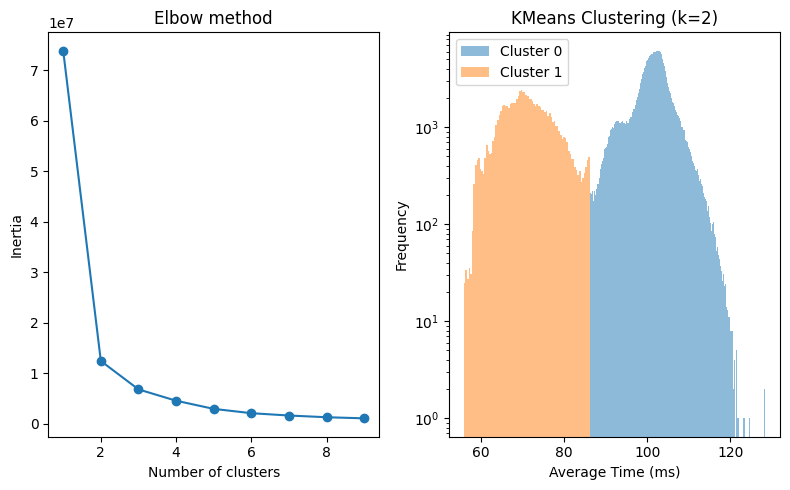

In [14]:
benchmark = "InvariantMassRandom"
problem_size = df["problem_size"].unique()[1]
df_imr = df[(df["benchmark"] == benchmark) & (df["problem_size"] == problem_size)]
data_imr = get_clustering_input(df_imr)

kmeans_imr = kmeans_clustering_1D(
    data_imr, n_clusters=2, xlabel="Average Time (ms)", ylabel="Frequency"
)

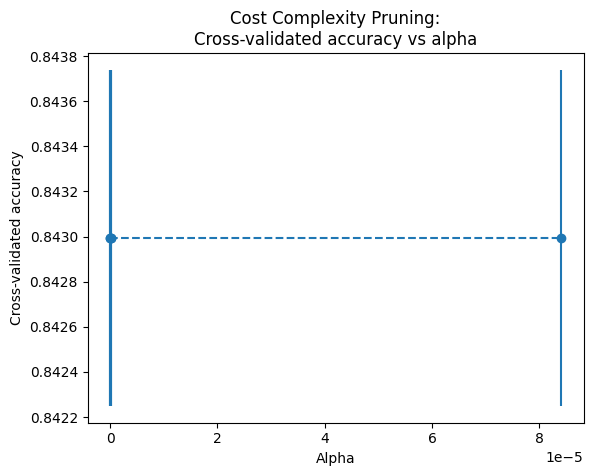

Alphas: [0.00000000e+00 2.20949466e-09 1.77502602e-07 1.99282269e-07
 8.40842507e-05]
Best on average: 0.0


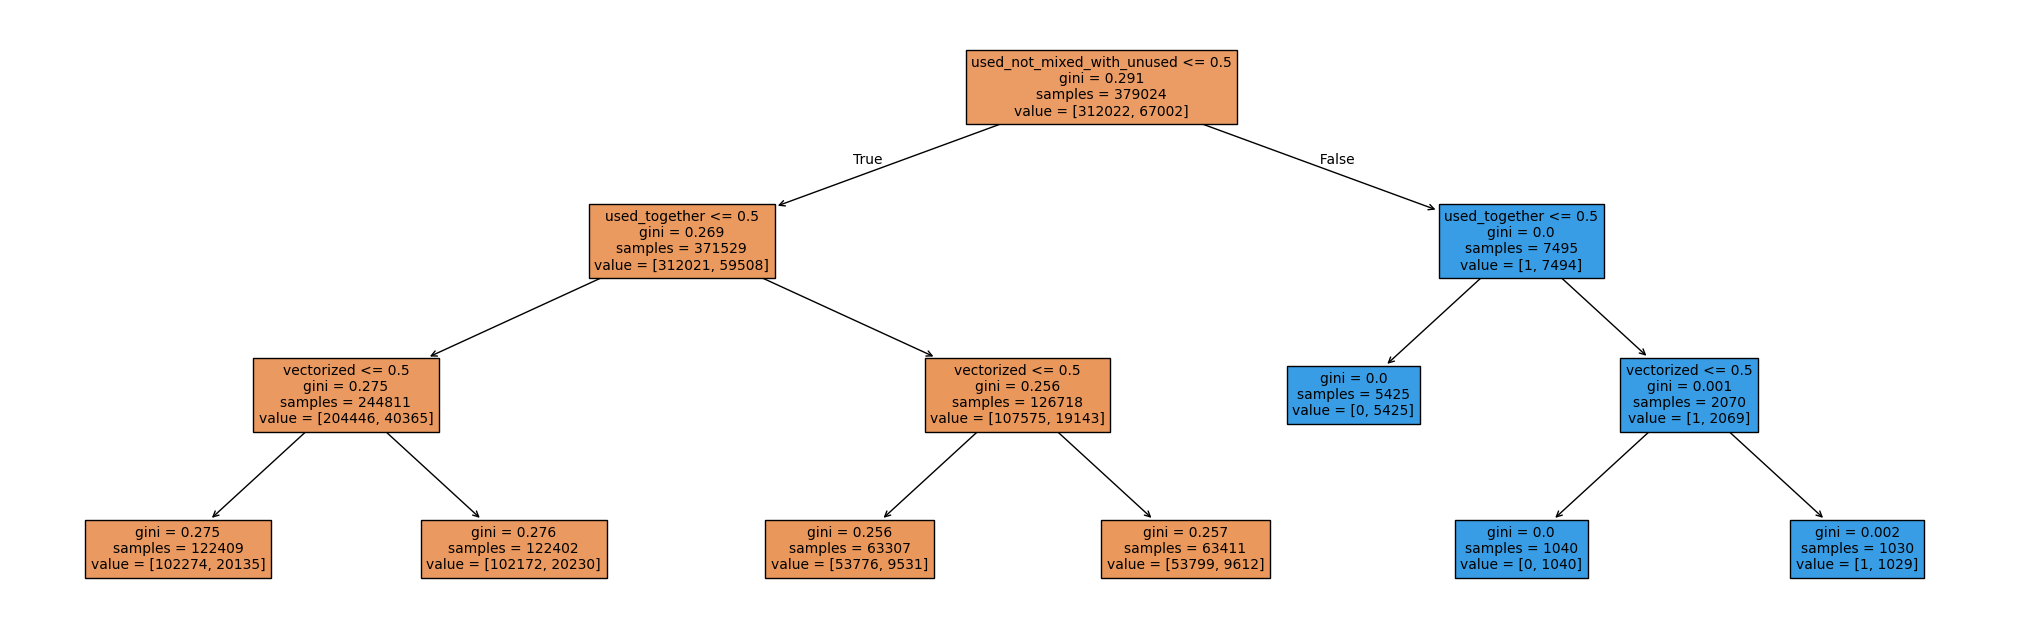

<Figure size 640x480 with 0 Axes>

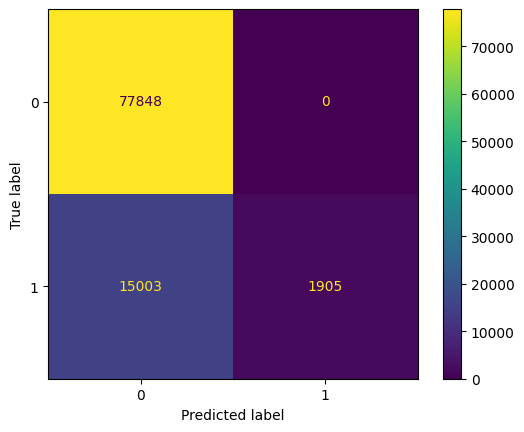

In [15]:
Y_imr = kmeans_imr.labels_
X_train_imr, X_test_imr, Y_train_imr, Y_test_imr = get_train_test_set(df_imr, Y_imr)
cl_tree_imr = classification_tree_1D(X_train_imr, X_test_imr, Y_train_imr, Y_test_imr)

In [16]:
print(cl_tree_imr.score(X_train_imr, Y_train_imr))
print(cl_tree_imr.score(X_test_imr, Y_test_imr))

0.8429941111908481
0.8416670184473807


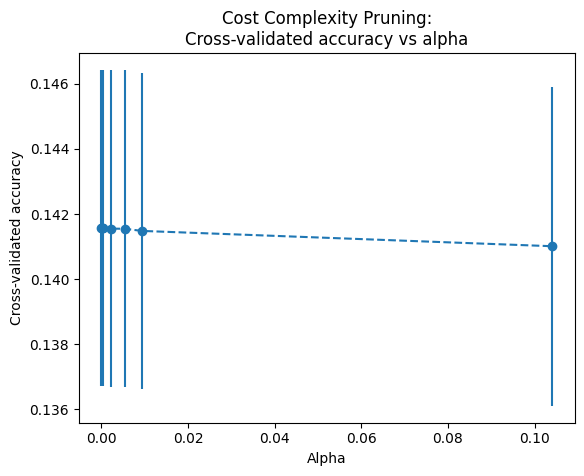

Alphas: [0.         0.00012987 0.00014226 0.00018268 0.00044119 0.00218026
 0.00547062 0.00926791 0.10411851]
Best on average: 0.0


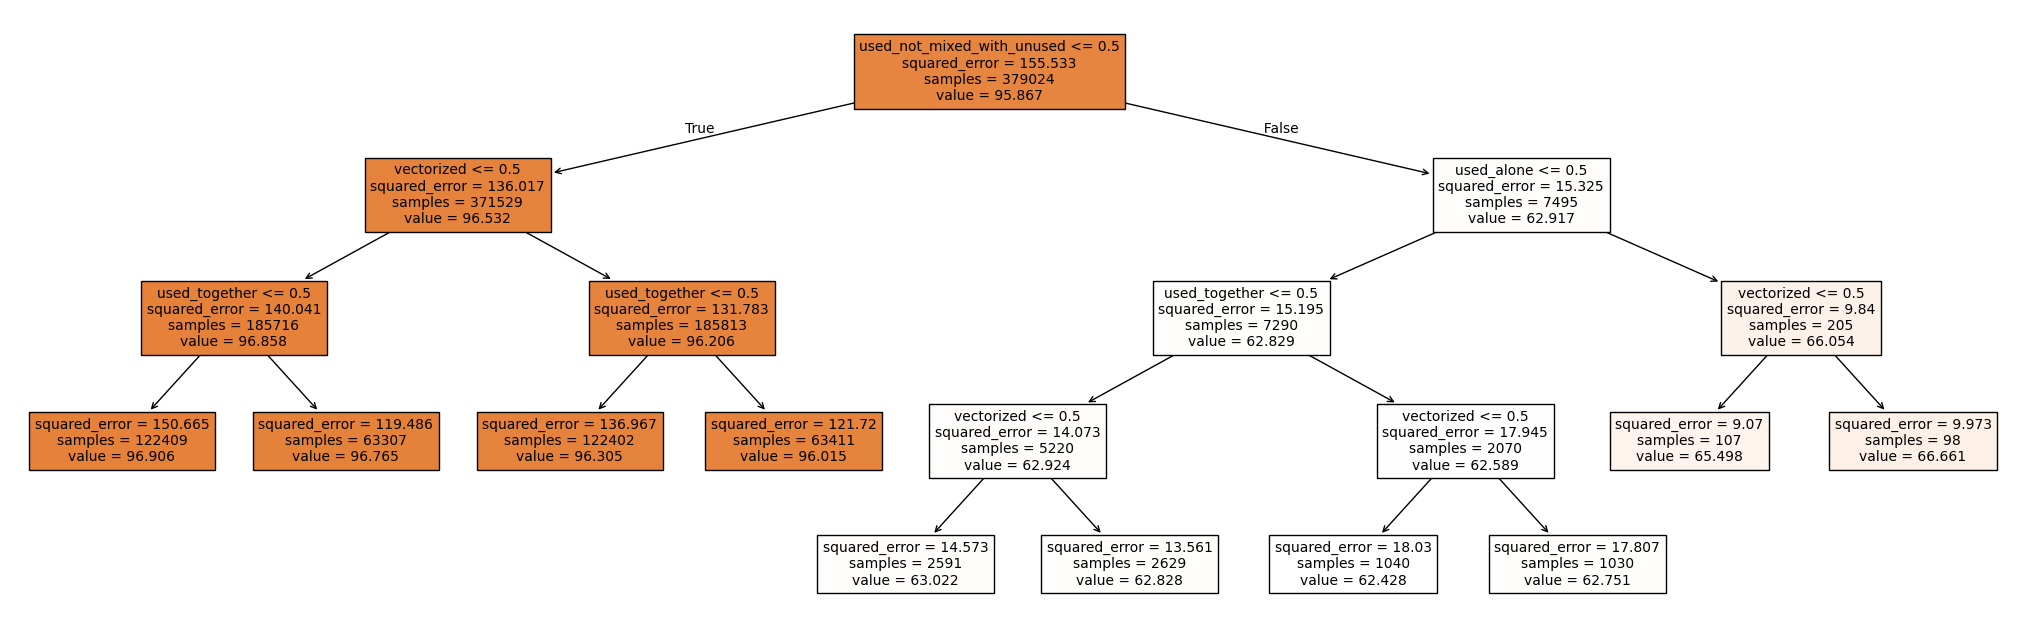

0.14160588450171896
0.1429679617965538


In [17]:
X_train_imr, X_test_imr, Y_train_imr, Y_test_imr = get_train_test_set(df_imr, data_imr)
reg_tree_imr = regression_tree_1D(X_train_imr, X_test_imr, Y_train_imr, Y_test_imr)
print(reg_tree_imr.score(X_train_imr, Y_train_imr))
print(reg_tree_imr.score(X_test_imr, Y_test_imr))

## InvariantMassSequential

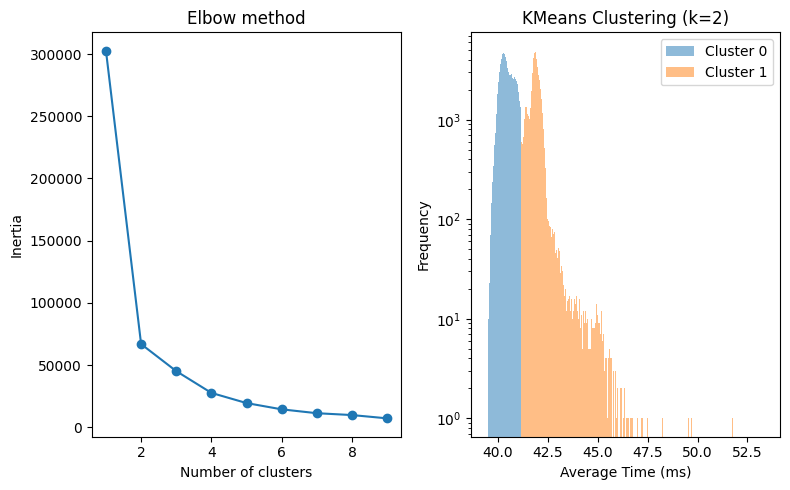

In [18]:
benchmark = "InvariantMassSequential"
problem_size = df["problem_size"].unique()[1]
df_ims = df[(df["benchmark"] == benchmark) & (df["problem_size"] == problem_size)]
data_ims = get_clustering_input(df_ims)

kmeans_ims = kmeans_clustering_1D(
    data_ims, n_clusters=2, xlabel="Average Time (ms)", ylabel="Frequency"
)

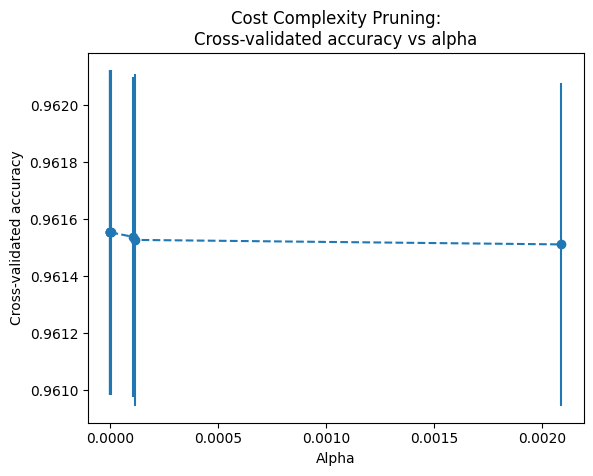

Alphas: [0.00000000e+00 3.67360427e-10 3.53477455e-08 6.40008049e-08
 9.28213066e-07 1.05758561e-04 1.15320140e-04 2.08881387e-03]
Best on average: 0.0


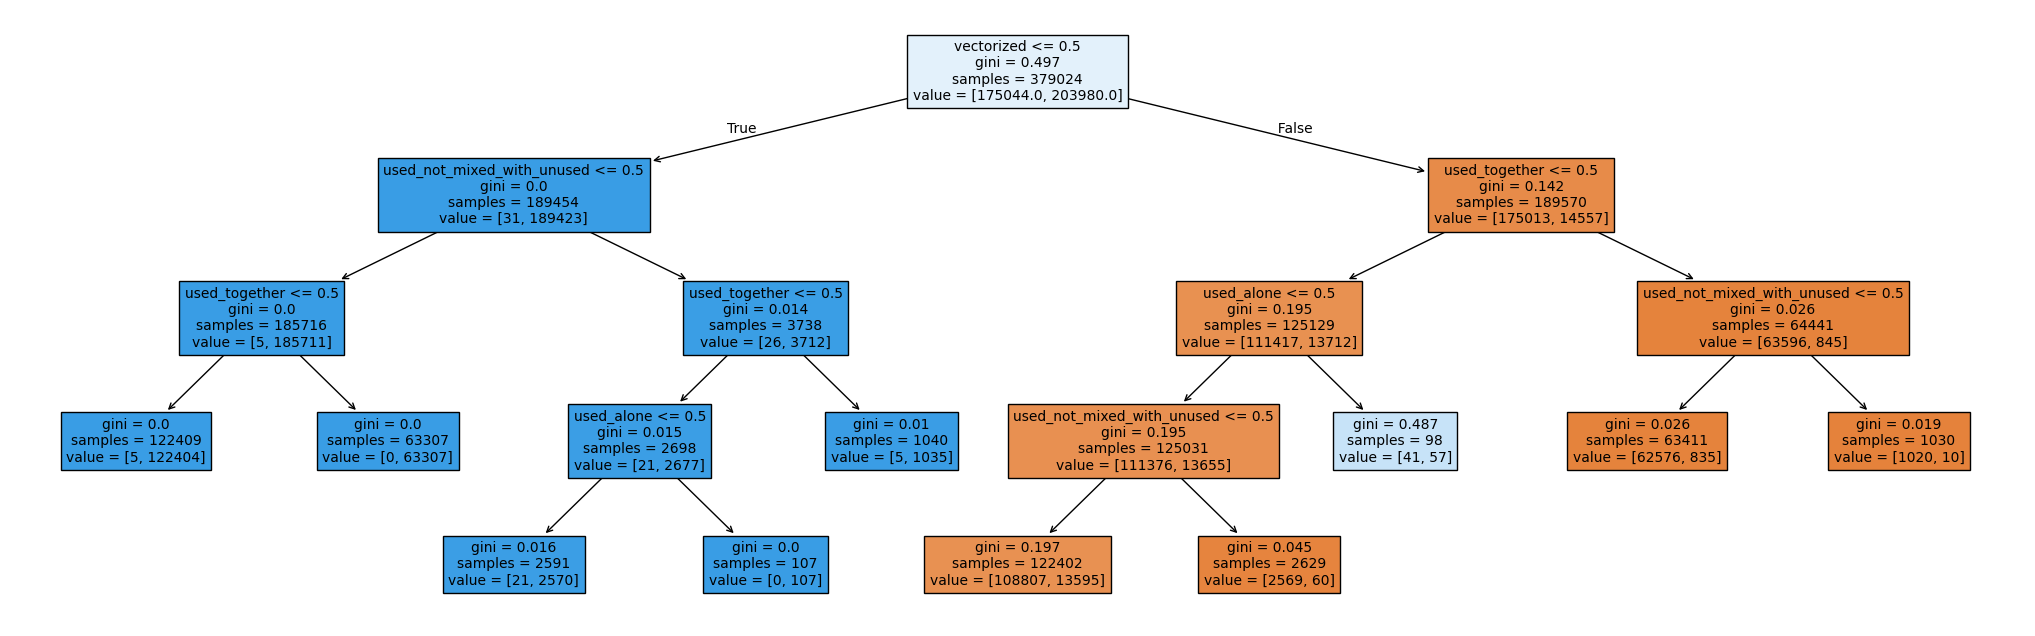

<Figure size 640x480 with 0 Axes>

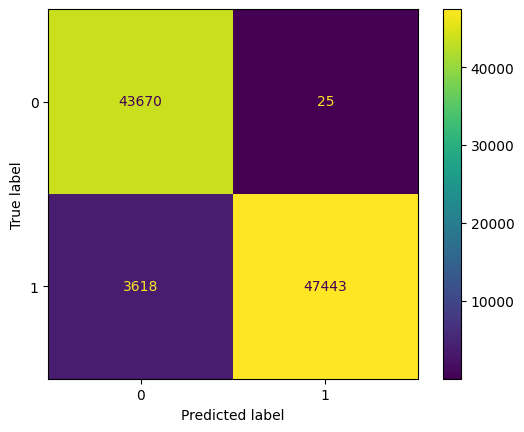

In [19]:
Y_ims = kmeans_ims.labels_
X_train_ims, X_test_ims, Y_train_ims, Y_test_ims = get_train_test_set(df_ims, Y_ims)

cl_tree_ims = classification_tree_1D(X_train_ims, X_test_ims, Y_train_ims, Y_test_ims)

In [20]:
print(cl_tree_ims.score(X_train_ims, Y_train_ims))
print(cl_tree_ims.score(X_test_ims, Y_test_ims))

0.9615538857697665
0.9615538857697665


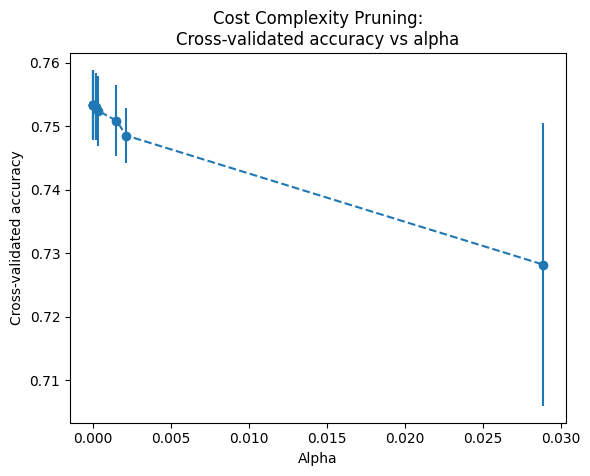

Alphas: [0.00000000e+00 6.70802351e-07 1.41319266e-05 5.72887846e-05
 2.39937593e-04 3.42055853e-04 1.52973626e-03 2.15687817e-03
 2.88620070e-02]
Best on average: 0.0


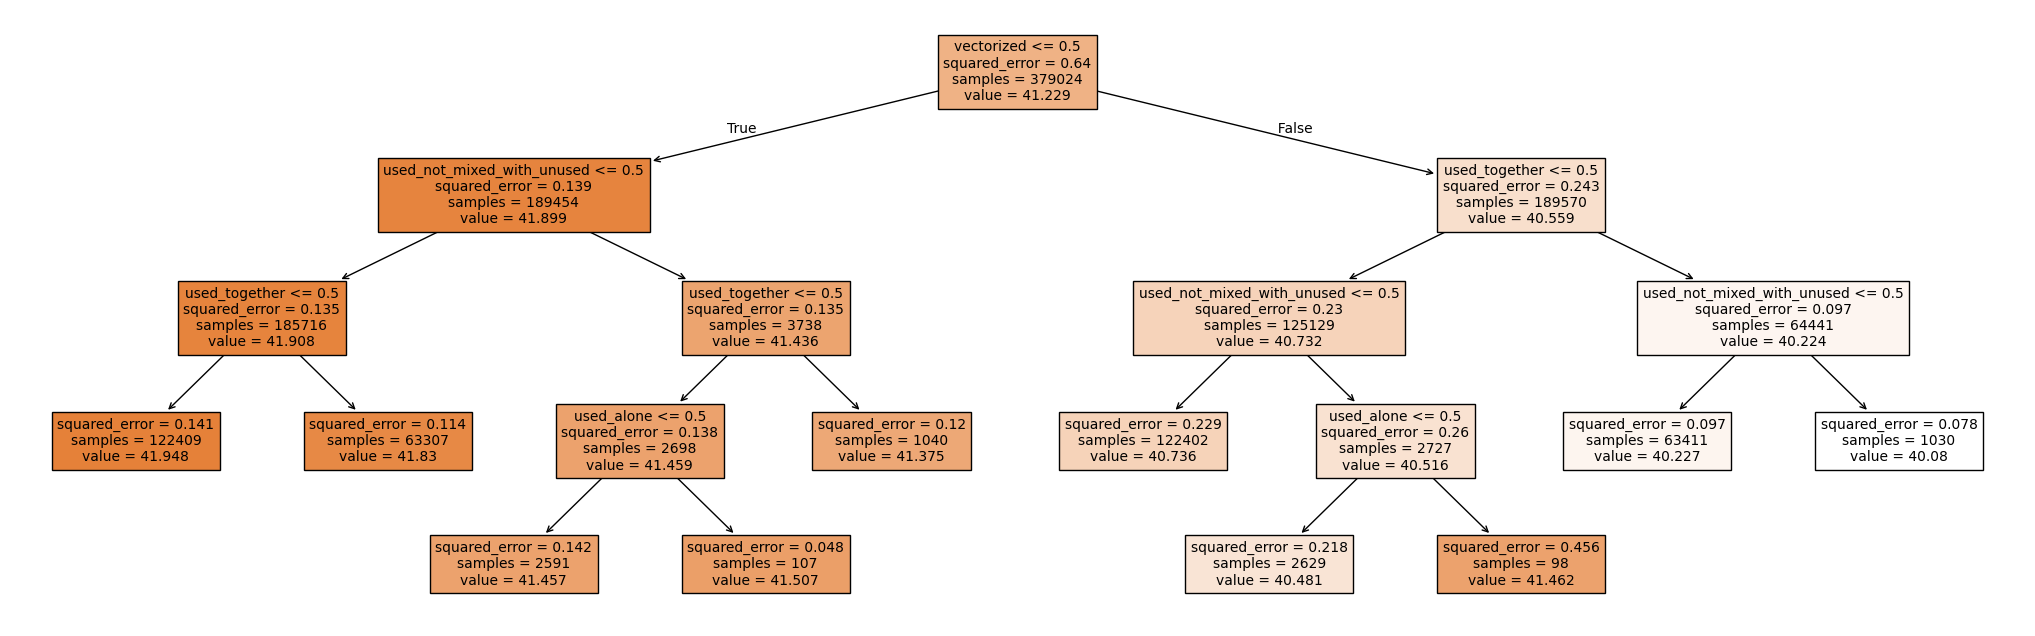

0.7533538121322387
0.7578959275629389


In [21]:
X_train_ims, X_test_ims, Y_train_ims, Y_test_ims = get_train_test_set(df_ims, data_ims)
reg_tree_ims = regression_tree_1D(X_train_ims, X_test_ims, Y_train_ims, Y_test_ims)
print(reg_tree_ims.score(X_train_ims, Y_train_ims))
print(reg_tree_ims.score(X_test_ims, Y_test_ims))

## DeltaR2Pairwise

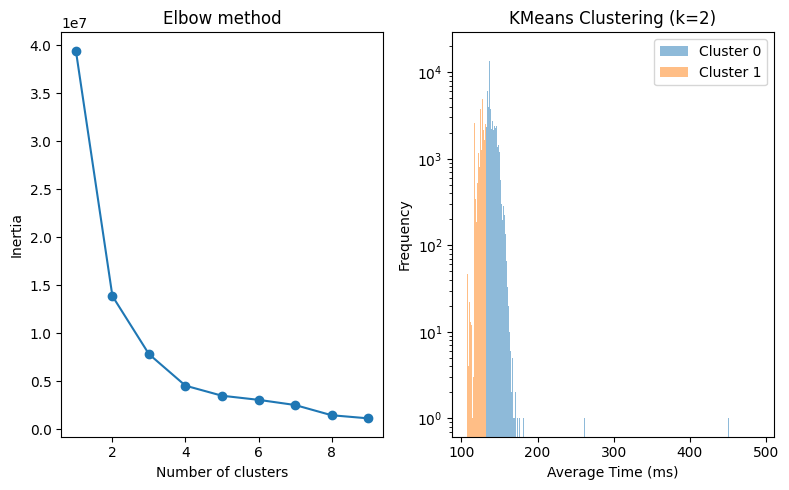

In [22]:
benchmark = "DeltaR2Pairwise"
problem_size = df["problem_size"].unique()[1]
df_dr2 = df[(df["benchmark"] == benchmark) & (df["problem_size"] == problem_size)]
data_dr2 = get_clustering_input(df_dr2)

kmeans_dr2 = kmeans_clustering_1D(
    data_dr2, n_clusters=2, xlabel="Average Time (ms)", ylabel="Frequency"
)

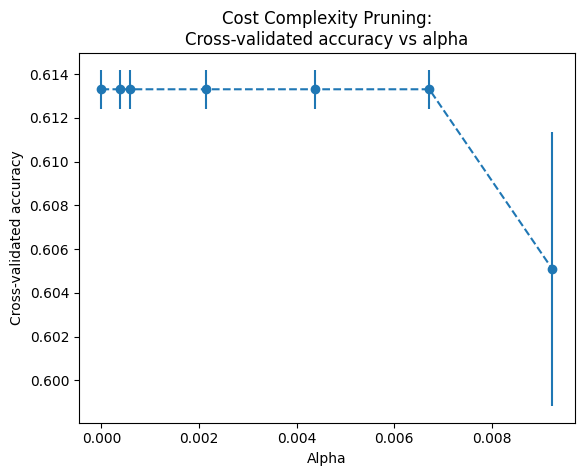

Alphas: [0.         0.00037424 0.00057548 0.00213682 0.00438109 0.00671778
 0.00923959]
Best on average: 0.0


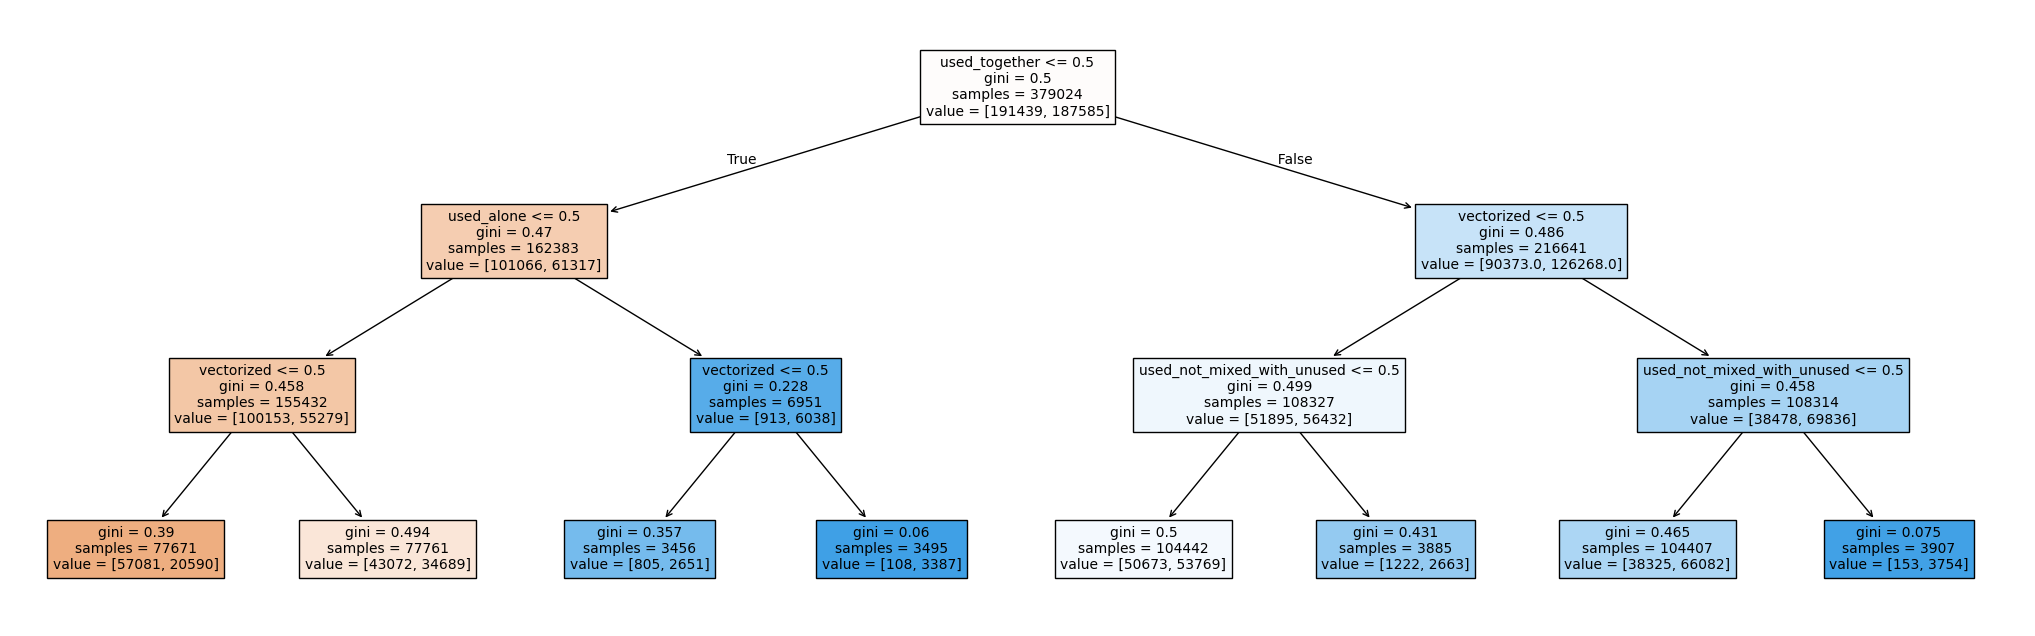

<Figure size 640x480 with 0 Axes>

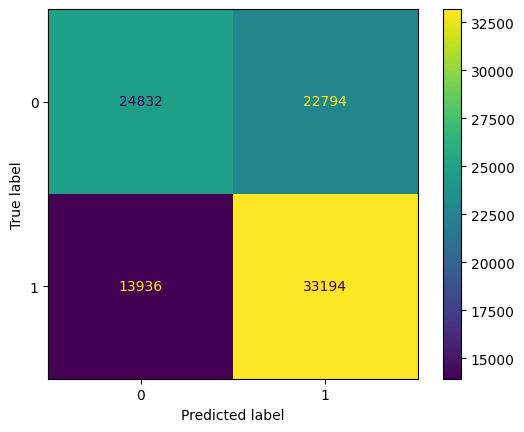

In [23]:
Y_dr2 = kmeans_dr2.labels_
X_train_dr2, X_test_dr2, Y_train_dr2, Y_test_dr2 = get_train_test_set(df_dr2, Y_dr2)

cl_tree_dr2 = classification_tree_1D(X_train_dr2, X_test_dr2, Y_train_dr2, Y_test_dr2)

In [24]:
print(cl_tree_dr2.score(X_train_dr2, Y_train_dr2))
print(cl_tree_dr2.score(X_test_dr2, Y_test_dr2))

0.6133094474228545
0.6123728312718983


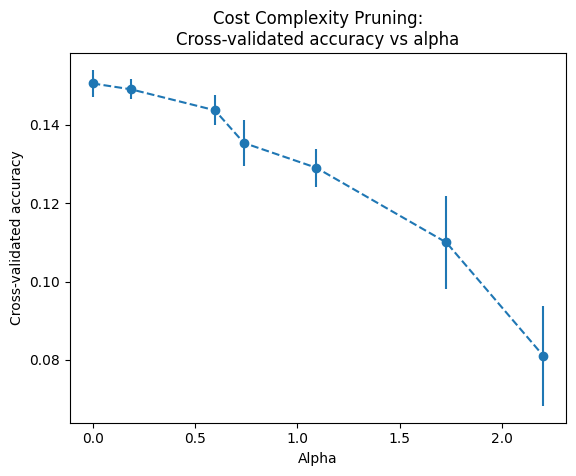

Alphas: [0.         0.18795183 0.59751549 0.73912703 1.09305261 1.7283257
 2.20279816]
Best on average: 0.0


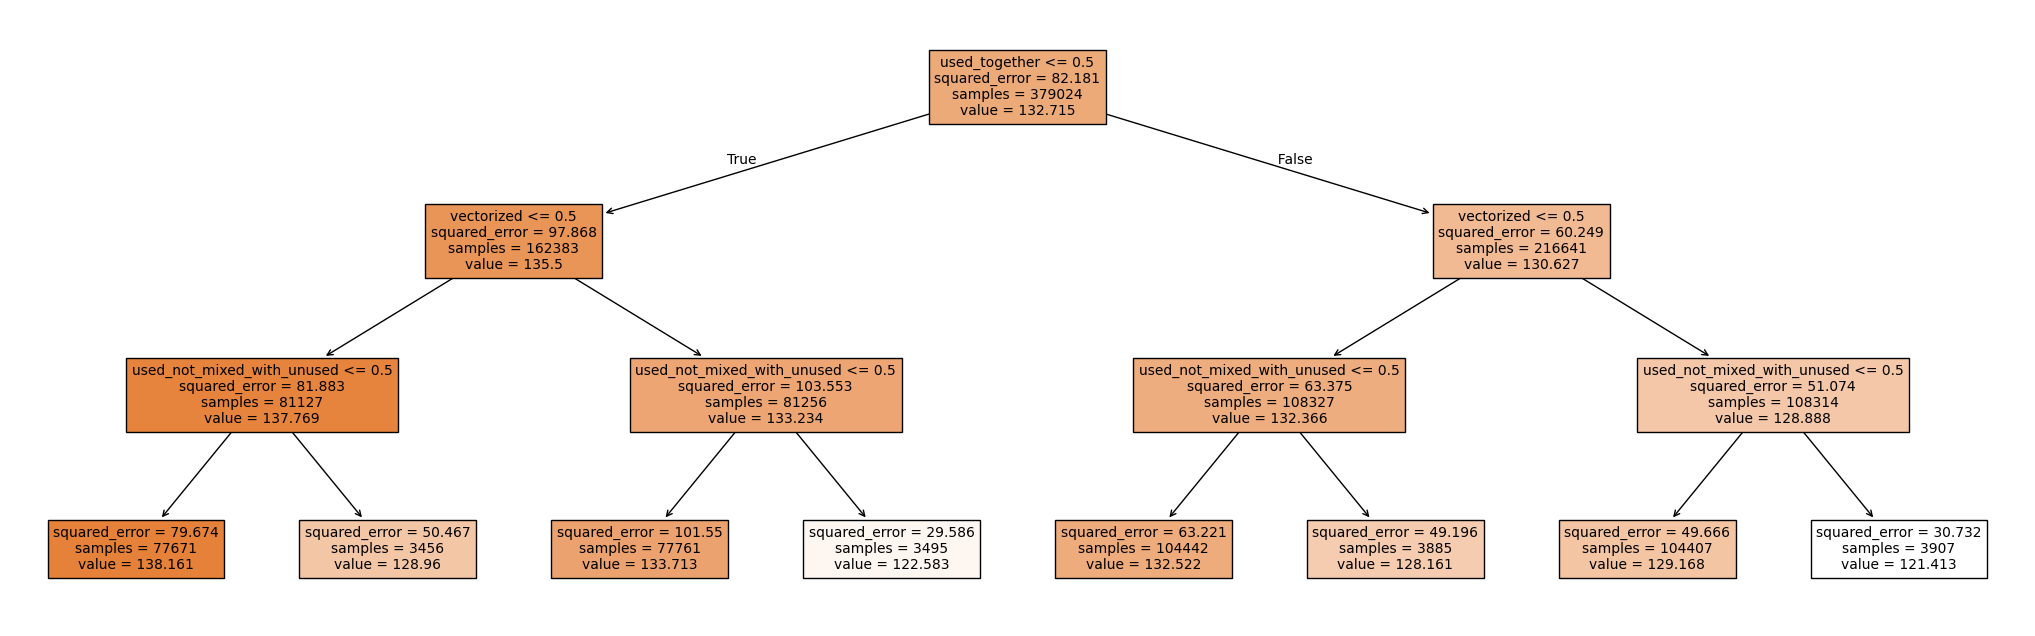

0.1504443715576843
0.14314559161357265


In [25]:
X_train_dr2, X_test_dr2, Y_train_dr2, Y_test_dr2 = get_train_test_set(df_dr2, data_dr2)
reg_tree_dr2 = regression_tree_1D(X_train_dr2, X_test_dr2, Y_train_dr2, Y_test_dr2)
print(reg_tree_dr2.score(X_train_dr2, Y_train_dr2))
print(reg_tree_dr2.score(X_test_dr2, Y_test_dr2))

## All Benchmarks

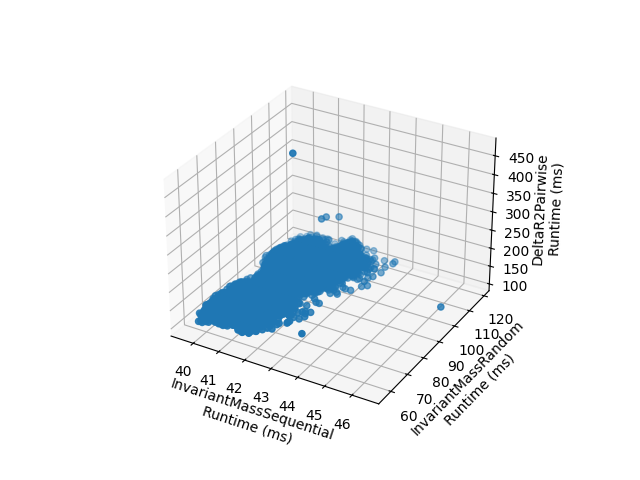

In [26]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(
    df_ims.groupby(["container", "vectorized"])["time"].mean(),
    df_imr.groupby(["container", "vectorized"])["time"].mean(),
    df_dr2.groupby(["container", "vectorized"])["time"].mean()
)
ax.set_xlabel('InvariantMassSequential\nRuntime (ms)')
ax.set_ylabel('InvariantMassRandom\nRuntime (ms)')
ax.set_zlabel('DeltaR2Pairwise\nRuntime (ms)')
plt.show()

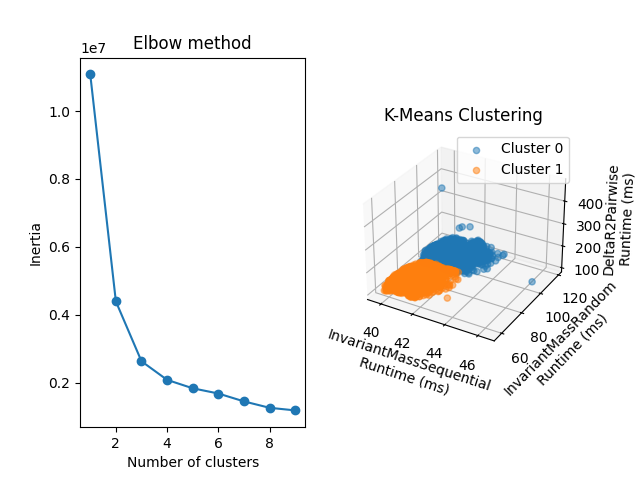

In [34]:
%matplotlib widget

import data


data_3d = np.hstack(
    (
        df_ims.groupby(["container", "vectorized"])["time"].mean().values.reshape(-1, 1),
        df_imr.groupby(["container", "vectorized"])["time"].mean().values.reshape(-1, 1),
        df_dr2.groupby(["container", "vectorized"])["time"].mean().values.reshape(-1, 1),
    )
)

inertias = []
max_k = 10
for i in range(1, max_k):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data_3d)
    inertias.append(kmeans.inertia_)

plt.close()
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(1, max_k), inertias, marker="o")
ax.set_title("Elbow method")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Inertia")

kmeans_3d = KMeans(n_clusters=2)
kmeans_3d.fit(data_3d)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title("K-Means Clustering")
# ax.scatter(kmeans_3d.cluster_centers_[:, 0], kmeans_3d.cluster_centers_[:, 1], kmeans_3d.cluster_centers_[:, 2], c='red', s=200, alpha=0.75, label='Centroids')

for label in np.unique(kmeans_3d.labels_):
    ax.scatter(
        data_3d[kmeans_3d.labels_ == label][:, 0],
        data_3d[kmeans_3d.labels_ == label][:, 1],
        data_3d[kmeans_3d.labels_ == label][:, 2],
        alpha=0.5,
        label=f"Cluster {label}",
    )
ax.legend()
ax.set_xlabel('InvariantMassSequential\nRuntime (ms)')
ax.set_ylabel('InvariantMassRandom\nRuntime (ms)')
ax.set_zlabel('DeltaR2Pairwise\nRuntime (ms)')

plt.show()

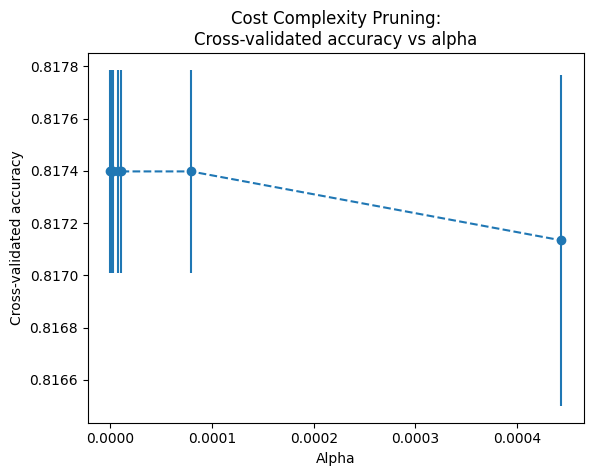

Alphas: [0.00000000e+00 1.70873795e-07 2.45628915e-06 7.05250643e-06
 1.01377260e-05 7.91191339e-05 4.43693072e-04]
Best on average: 0.0


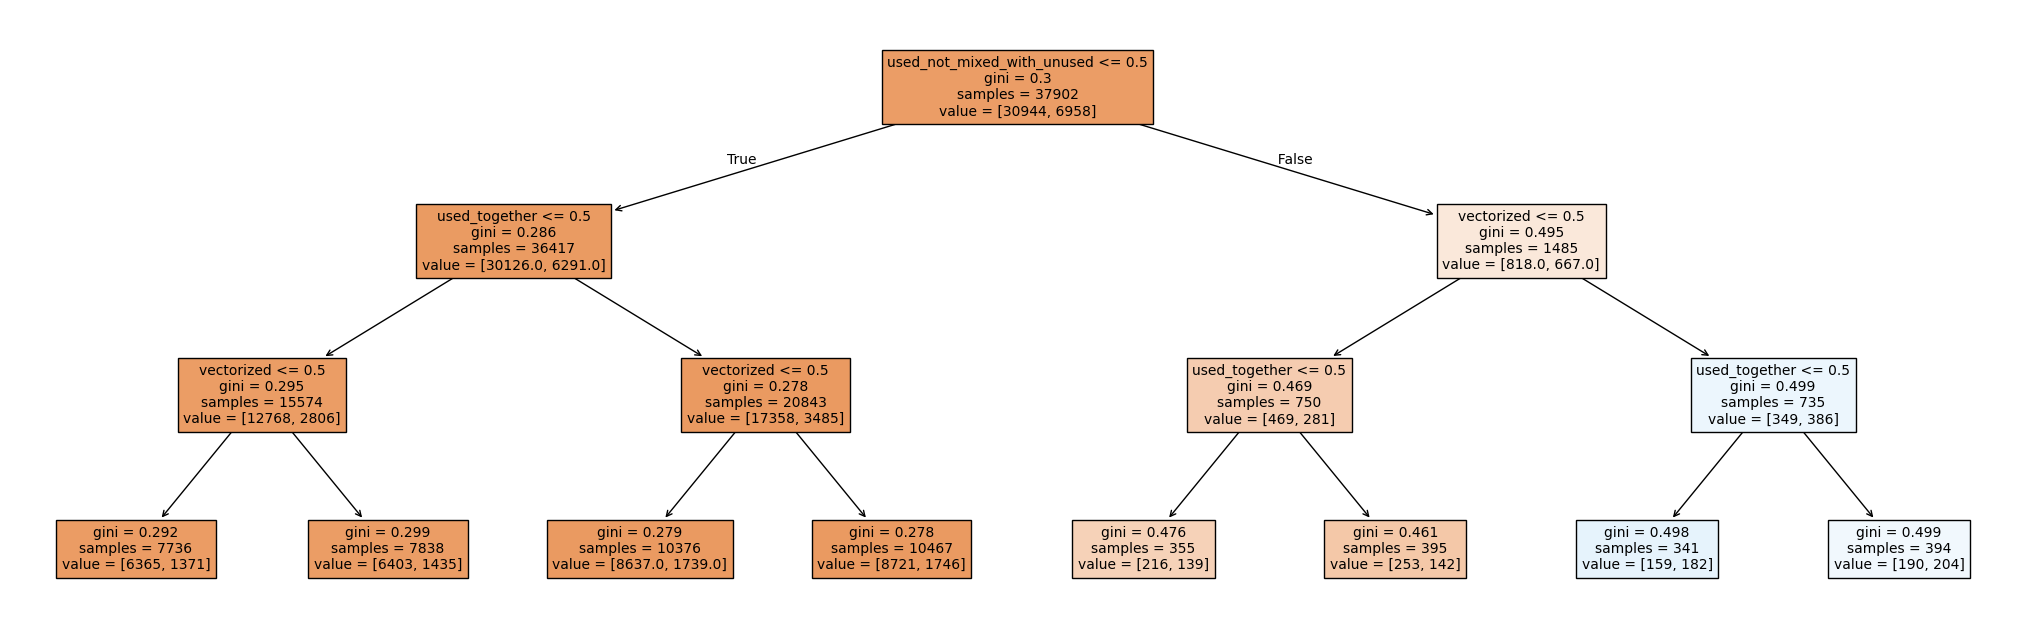

<Figure size 640x480 with 0 Axes>

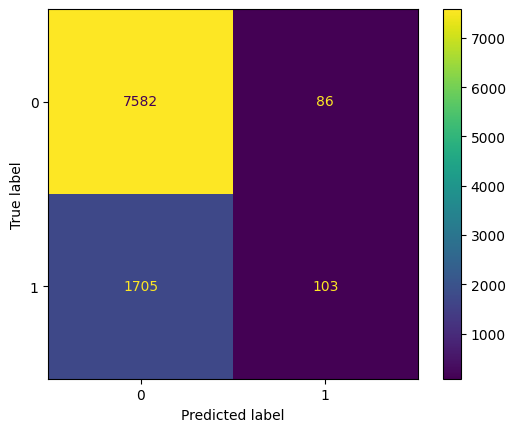

0.8173974988127276
0.8109962009286619


In [39]:
%matplotlib inline
plt.close()

X_3d = df_dr2.groupby(["container", "vectorized"])[feature_columns].first()
Y_3d = kmeans_3d.labels_
X_train_3d, X_test_3d, Y_train_3d, Y_test_3d = train_test_split(
    X_3d, Y_3d, test_size=0.2, random_state=42
)

cl_tree_3d = classification_tree_1D(X_train_3d, X_test_3d, Y_train_3d, Y_test_3d)
print(cl_tree_3d.score(X_train_3d, Y_train_3d))
print(cl_tree_3d.score(X_test_3d, Y_test_3d))

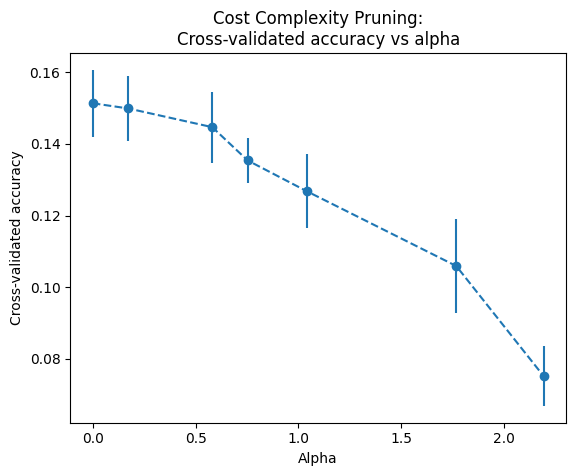

Alphas: [0.         0.17190722 0.58107494 0.75281119 1.04092578 1.76691218
 2.19133835]
Best on average: 0.0


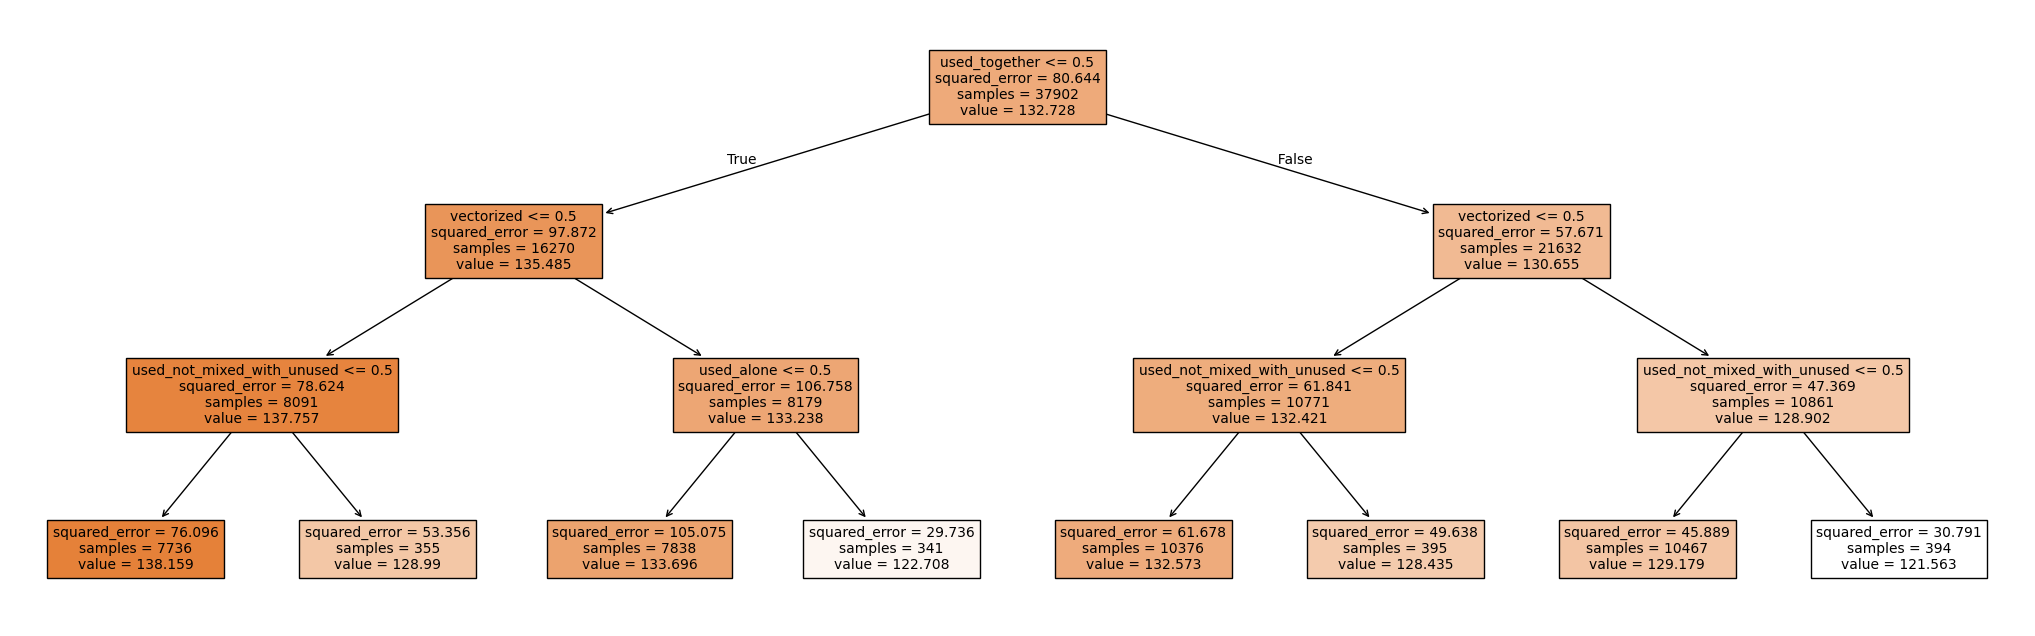

0.15154886144817703
0.16194047064122497


In [40]:
X_train_3d, X_test_3d, Y_train_3d, Y_test_3d = train_test_split(
    X_3d, df_dr2.groupby(["container", "vectorized"])["time"].mean(), test_size=0.2, random_state=42
)
reg_tree_3d = regression_tree_1D(X_train_3d, X_test_3d, Y_train_3d, Y_test_3d)
print(reg_tree_3d.score(X_train_3d, Y_train_3d))
print(reg_tree_3d.score(X_test_3d, Y_test_3d))